In [1]:
CUDA_INDEX = 0
NAME = 'PubMed'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [5]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/outer_test.pt', map_location='cpu')
queries, targets, lb, ub = outer_test_set

In [ ]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

99.16
99.33
98.61
92.36
98.53
92.89
90.67


In [7]:
from scipy.stats import kendalltau
sed = (lb+ub)/2
for i, (label, pred) in enumerate(preds):
    tmp = []
    for i in range(len(queries)):
        tmp.append(kendalltau(sed[i], pred[i], nan_policy='omit')[0])
    tau = sum(tmp)/len(tmp)
    print(f'{tau:.3f}')

0.901
0.873
0.865
0.852
0.736
0.769


In [6]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

99.16
99.33
98.61
92.36
98.53
92.89
90.67


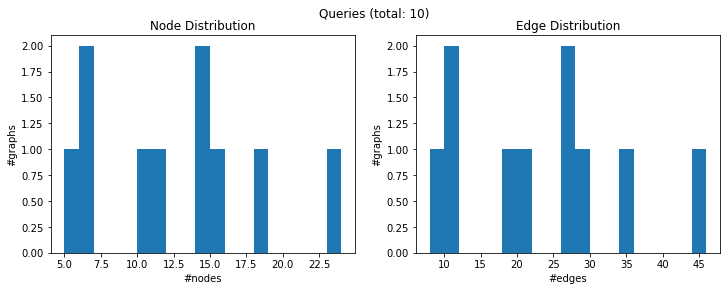

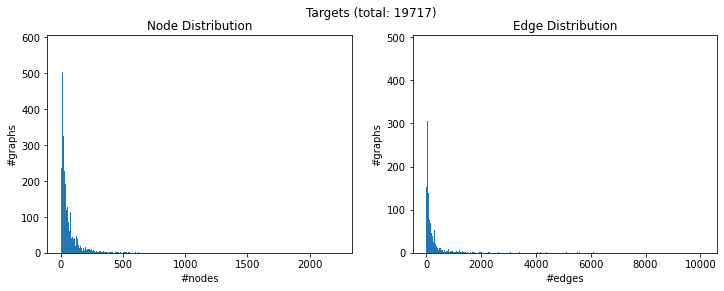

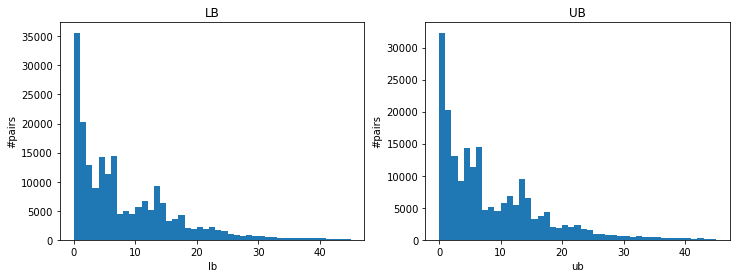

In [6]:
viz.plot_dataset_dist(outer_test_set)

In [8]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

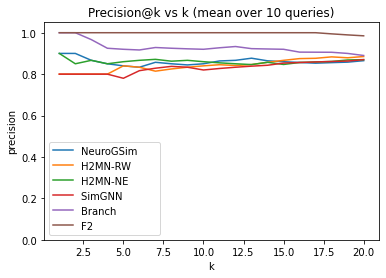

90.00 / 84.00 / 85.00 / 86.00 / 86.50
80.00 / 84.00 / 84.00 / 86.67 / 88.50
90.00 / 86.00 / 86.00 / 84.67 / 87.00
80.00 / 78.00 / 82.00 / 85.33 / 87.00
100.00 / 92.00 / 92.00 / 92.00 / 89.00
100.00 / 100.00 / 100.00 / 100.00 / 98.50


In [9]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [12]:
len(targets)

19717

In [14]:
for label, pred in preds:
#     print(f'{label}', end='\t')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([100]), lb[:5], ub[:5], pred[:5])).item()
    print(f'{tmp*100:.2f}')
#     print()

RuntimeError: CUDA out of memory. Tried to allocate 1.81 GiB (GPU 5; 10.92 GiB total capacity; 1.82 GiB already allocated; 811.00 MiB free; 1.82 GiB reserved in total by PyTorch)

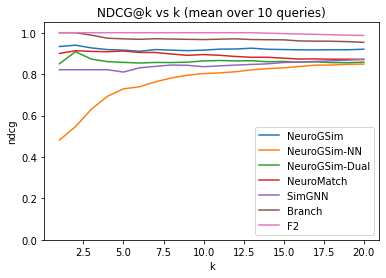

93.33 / 91.60 / 91.58 / 91.88 / 92.04
48.16 / 72.90 / 80.27 / 83.04 / 84.85
85.00 / 85.68 / 86.37 / 86.13 / 85.78
90.00 / 91.15 / 89.45 / 87.68 / 87.07
82.13 / 81.00 / 83.59 / 85.61 / 87.18
100.00 / 97.04 / 96.69 / 96.55 / 95.34
100.00 / 100.00 / 100.00 / 99.57 / 98.69


In [11]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG@k vs k (mean over {len(queries)} queries)')

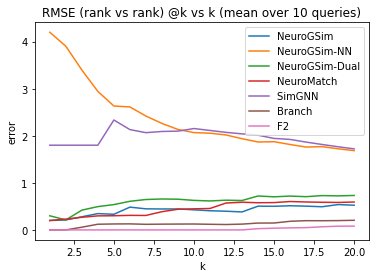

0.200 / 0.332 / 0.427 / 0.502 / 0.525
4.200 / 2.633 / 2.068 / 1.874 / 1.685
0.300 / 0.538 / 0.628 / 0.703 / 0.732
0.200 / 0.301 / 0.448 / 0.581 / 0.593
1.800 / 2.335 / 2.154 / 1.944 / 1.722
0.000 / 0.126 / 0.125 / 0.147 / 0.204
0.000 / 0.000 / 0.000 / 0.037 / 0.081


In [12]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

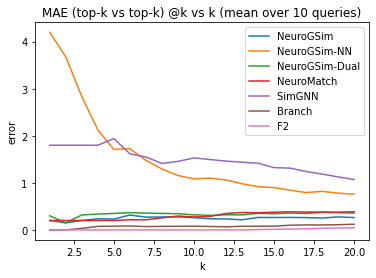

0.200 / 0.230 / 0.260 / 0.263 / 0.263
4.200 / 1.710 / 1.085 / 0.900 / 0.760
0.300 / 0.350 / 0.320 / 0.343 / 0.358
0.200 / 0.200 / 0.275 / 0.377 / 0.388
1.800 / 1.940 / 1.530 / 1.323 / 1.070
0.000 / 0.080 / 0.080 / 0.080 / 0.120
0.000 / 0.000 / 0.000 / 0.013 / 0.045


In [13]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)